In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pybedtools
from statannotations.Annotator import Annotator
import math
from collections import defaultdict
import bisect
import itertools
from mphelper import ProcessWrapPool
from pathlib import Path

In [3]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [4]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# TE proportion

In [5]:
inputfile = f"{PROJECT_DIR_r}other/rmsk/TE_filtered.bed.gz"
df_TE = pd.read_table(inputfile, header=None)
df_TE.head(2)

,0,1,2,3,4,5,6,7
0,chr1,11485,11676,-,L1MC5a,LINE,L1,21.2
1,chr1,11678,11780,-,MER5B,DNA,hAT-Charlie,29.4


In [6]:
TEclass = ["SINE", "LINE", "LTR", "DNA"]
colors = ["#80b1d3", "#ffed6f", "#b3de69", "#fdb462"]

In [7]:
# TE distribution

df_TE = df_TE[df_TE[5].isin(TEclass)]
TE_counts = {}
for k in TEclass:
	TE_counts[k] = len(df_TE[df_TE[5]==k])

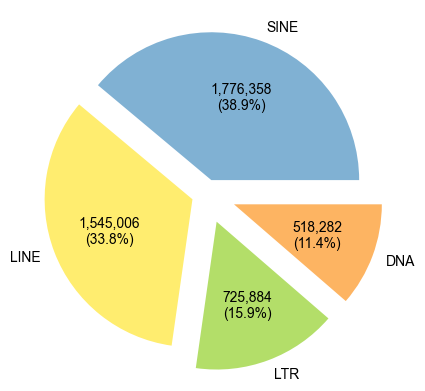

In [8]:
labels = []
sizes = []
for x, y in TE_counts.items():
	labels.append(x)
	sizes.append(y)
explode = [0.1, 0.1, 0.2, 0.2]

def my_fmt(x):
	num = str(int(round(len(df_TE)*x/100,0)))
	n_int = len(num)
	n_comma = math.floor(n_int / 3)
	n_left = n_int % 3
	num2 = ""
	for n in range(1,n_comma+1):
		start = -3*n
		if n == 1:
			num2 = "," + num[start:] + num2
		else:
			end = -3*(n-1)
			num2 = "," + num[start:end] + num2
	num2 = num[:n_left] + num2
	if n_left == 0:
		num2 = num2[1:]
	return '{}\n({:.1f}%)'.format(num2, x)

plt.pie(sizes, labels=labels, explode=explode, autopct=my_fmt, colors=colors)
plt.show()

# TEs & TREs

## TE vs. Non-TE

In [9]:
s = "C1"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]

In [10]:
# Assign PROcap element to one TE (>50% TRE length)

mapping_all = defaultdict(dict)
mapping_rev = defaultdict(set)
b1 = pybedtools.BedTool(f"{PROJECT_DIR_r}other/rmsk/TE_filtered.bed.gz")
for p, d in itertools.product(ps, ds):
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed")
	overlaps = b2.intersect(b1, wao=True, f=0.5)
	for i in overlaps:
		# TREs
		chrom1, start1, end1 = i.fields[:3]
		# TEs
		start2, end2, _, _, te_class, te_family = i.fields[-8:-2]
		if int(i.fields[-1]) > 0:
			mapping_all[(p,d)][(chrom1, start1, end1)] = (chrom1, start2, end2, te_class, te_family)
			mapping_rev[(chrom1, start2, end2)].add((chrom1, start1, end1, p, d))
		else:
			mapping_all[(p,d)][(chrom1, start1, end1)] = "."

In [11]:
len(mapping_rev), len([k for k in mapping_rev if len(mapping_rev[k]) > 1]), sum([len(mapping_rev[k]) for k in mapping_rev if len(mapping_rev[k]) > 1])

(2971, 22, 48)

In [12]:
# If > 1 TREs overlap with one TE, remove all of them

mapping = defaultdict(dict)
for k in mapping_all:
	for e in mapping_all[k]:
		if mapping_all[k][e] == ".":
			mapping[k][e] = mapping_all[k][e]
		else:
			chrom, start, end = mapping_all[k][e][:3]
			if len(mapping_rev[(chrom, start, end)]) == 1:
				mapping[k][e] = mapping_all[k][e]

In [13]:
results = []
for p, d in itertools.product(ps, ds):
	rate = sum([1 for e in mapping[(p,d)] if mapping[(p,d)][e] != "."])/len(mapping[(p,d)])
	row = [d, p.capitalize(), rate*100, (1-rate)*100]
	results.append(row)
df_prop = pd.DataFrame(results, columns=["Group1", "Group2", "TE", "Non-TE"])

In [14]:
def plot_prop(d, df, color, legend_y, figy, outputfile):
	df = df[df["Group1"]==d]
	ax = df.set_index("Group2").plot(kind="bar", stacked=True, 
									color=color,
								    figsize=(3, figy))
	ax.spines[["right", "top"]].set_visible(False)
	handles, labels = ax.get_legend_handles_labels()
	ax.legend(reversed(handles), reversed(labels), bbox_to_anchor=(0.5, legend_y), 
			  ncol=2, loc="upper center", fontsize=sfontsize)
	
	ax.set_ylabel("TREs (%)", fontsize=bfontsize)
	ax.tick_params(axis="y", labelsize=sfontsize)
	
	ax.set_xlabel("")
	ax.tick_params(axis="x", labelsize=bfontsize, rotation=0)
	
	for p in ax.patches:
		width, height = p.get_width(), p.get_height()
		x, y = p.get_xy() 
		ax.text(x+width/2, 
				y+height/2, 
				"{:.1f}".format(height), 
				fontsize=sfontsize,
				ha="center", 
				va="center")
	
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

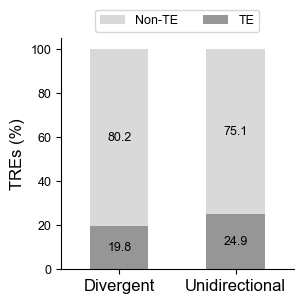

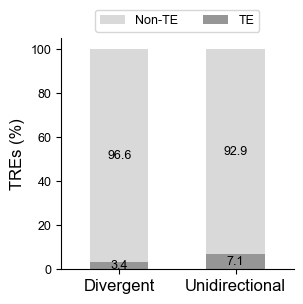

In [15]:
for d in ds:
	folder = "figures/" if d == "distal" else "other_figures/"
	outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig5a.pdf"
	plot_prop(d, df_prop, ["#969696", "#d9d9d9"], 1.15, 3, outputfile)

## TE class

In [15]:
n_TEclass = {}
for k in mapping:
	n_TEclass[k] = defaultdict(int)
	for e in mapping[k]:
		if mapping[k][e] != ".":
			n_TEclass[k][mapping[k][e][-2]] += 1

In [16]:
results = []
for p, d in n_TEclass:
	row1 = [n_TEclass[(p,d)][te] for te in TEclass[::-1]]
	row2 = [i/sum(row1)*100 for i in row1]
	results.append([d, p.capitalize()] + row2)
df_prop2 = pd.DataFrame(results, columns=["Group1", "Group2"] + TEclass[::-1])

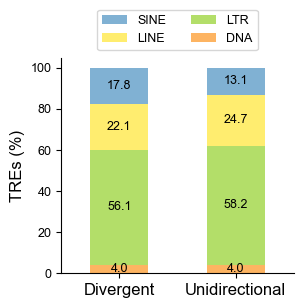

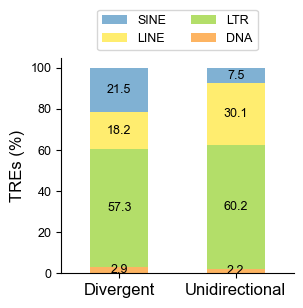

In [17]:
for d in ds:
	folder = "figures/" if d == "distal" else "other_figures/"
	outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig5b.pdf"
	plot_prop(d, df_prop2, colors[::-1], 1.25, 2.8, outputfile)

## TE class enrichment

In [18]:
TEfamily = set([mapping[k][e][-1] for k in mapping for e in mapping[k] if mapping[k][e][-1] != "."])
len(TEfamily)

22

In [19]:
# TE family - TE class

TE_mapping = {}
for index, row in df_TE.iterrows():
	TE_mapping[row[6]] = row[5]

In [20]:
# total bp in TE family

te_length = {}
for te in TEfamily:
	df = df_TE[df_TE[6]==te]
	te_length[te] = sum(df[2]-df[1])

In [21]:
# genome size (no Ns)
# https://www.repeatmasker.org/species/hg.html

tot_length = 3049315783

In [22]:
n_TEfamily = {}
for k in mapping:
	n_TEfamily[k] = defaultdict(int)
	for e in mapping[k]:
		if mapping[k][e] != ".":
			n_TEfamily[k][mapping[k][e][-1]] += 1

In [23]:
results = []
for p, d in n_TEfamily:
	tot = len(mapping[(p,d)])
	for te in TEfamily:
		n = n_TEfamily[(p,d)][te]
		prob = te_length[te]/tot_length
		enr = (n/tot)/prob
		if n > 0:
			enr = np.log2(enr)
			results.append([d, p.capitalize(), TE_mapping[te], te, enr])
df_enrich = pd.DataFrame(results, columns=["Group1", "Group2", "TE_class", "TE_family", "Enrichr"])
df_enrich.head(2)

,Group1,Group2,TE_class,TE_family,Enrichr
0,distal,Divergent,LTR,ERVK,1.259954
1,distal,Divergent,DNA,TcMar-Tc2,-2.190134


In [24]:
def plot_enrichr(d, df, outputfile):
	fig, ax = plt.subplots(figsize=(3.5,3))
	df = df[df["Group1"]==d]
	hue_plot_params = { "data": df,
						"x": "Group2",
						"y": "Enrichr",
						"hue": "TE_class",
						"hue_order": TEclass,
						"palette": colors,
						"showfliers": False,
						"ax": ax
						}
	g = sns.boxplot(**hue_plot_params)
	g.spines[["right", "top"]].set_visible(False)
	g.legend(bbox_to_anchor=(0.5, 1.15), ncol=4, loc='upper center', fontsize=sfontsize)

	g.set_ylim([-7.5, 2.5])
	g.set_ylabel("log$_2$Enrichment", fontsize=bfontsize)
	g.get_yaxis().set_label_coords(-0.12, 0.5)
	g.tick_params(axis="y", labelsize=sfontsize) 
	
	g.set_xlabel("")
	g.tick_params(axis="x", labelsize=bfontsize, rotation=0) 
	
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

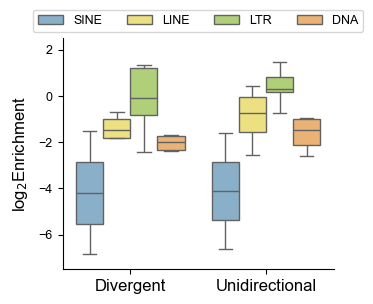

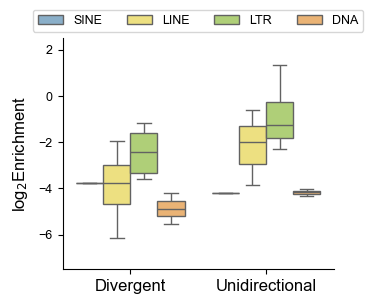

In [25]:
for d in ds:
	folder = "figures/" if d == "distal" else "other_figures/"
	outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig5c.pdf"
	plot_enrichr(d, df_enrich, outputfile)

## Distance

In [26]:
# Get a dataframe with TREs without overlapping any TEs

results = []
for p, d in itertools.product(ps, ds):
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed")
	nonoverlaps = b2.intersect(b1, v=True)
	for i in nonoverlaps:
		results.append(i.fields[:3] + [p])
df_nonoverlaps = pd.DataFrame(results)
outputfile = f"{PROJECT_DIR_o}temp/nonTE_TREs.bed"
df_nonoverlaps.to_csv(outputfile, sep="\t", index=False, header=None)

In [27]:
b = pybedtools.BedTool(outputfile)
b.sort().saveas(outputfile)

<BedTool(/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/temp/nonTE_TREs.bed)>

In [28]:
sorted_list = [(i.fields[0], int(i.fields[1]), int(i.fields[2]), i.fields[3]) for i in b]

In [29]:
def find_closest(element_A, sorted_list_B, p):
	chrom, start_A, end_A = element_A
	positions_B = [(b[1], b[2]) for b in sorted_list_B if b[0]==chrom and b[3]==p]
	
	pos_starts = [pos[0] for pos in positions_B]
	pos_ends = [pos[1] for pos in positions_B]
	
	idx = bisect.bisect_left(pos_starts, start_A)
	if idx == 0:
		closest_idx = idx
		min_distance = pos_starts[closest_idx] - end_A
	elif idx == len(positions_B):
		closest_idx = idx-1
		min_distance = start_A - pos_ends[closest_idx]
	else:
		dist = start_A - pos_ends[idx-1]
		dist2 = pos_starts[idx] - end_A
		
		if dist <= dist2:
			closest_idx = idx-1
			min_distance = dist
		else:
			closest_idx = idx
			min_distance = dist2

	start, end = positions_B[closest_idx]
	
	return chrom, str(start), str(end), min_distance

In [30]:
def get_distances(df, p, sorted_list):
	closest = {}
	for index, row in df.iterrows():
		chrom, start, end = row[:3]
		closest[(chrom, str(start), str(end))] = find_closest((chrom, start, end), sorted_list, p)
	return closest

In [31]:
# Find the closest non-TE TREs for each TE

pwpool = ProcessWrapPool(len(ps)*len(TEclass))

map_dict = {}
for p, te in itertools.product(ps, TEclass):
	df = df_TE[df_TE[5]==te]
	map_dict[(p, te)] = pwpool.run(get_distances, args=[df, p, sorted_list])

In [39]:
len(pwpool.finished_tasks)

8

In [40]:
temp = pwpool.get()

In [41]:
closest = {}
for p, te in itertools.product(ps, TEclass):
	closest[(p, te)] = temp[map_dict[(p, te)]]

In [42]:
pwpool.close()

In [43]:
inputfiles = [f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed" for p, d in itertools.product(ps, ds)]
bs = [pybedtools.BedTool(inputfile) for inputfile in inputfiles]
outputfile = f"{PROJECT_DIR_o}temp/all_procap.bed"
bs[0].cat(*bs[1:]).sort().merge().saveas(outputfile)

<BedTool(/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/temp/all_procap.bed)>

In [44]:
# Get TEs not overlapping with TREs

b2 = pybedtools.BedTool(f"{PROJECT_DIR_o}temp/all_procap.bed")
nonTREs = set([tuple(i.fields[:3]) for i in b1.intersect(b2, v=True)])

In [45]:
results = []
for target_p, te_class in closest:
	for te in closest[(target_p, te_class)]:
		if te in nonTREs:
			results.append([target_p, te_class, ".", "Non-TRE TEs", closest[(target_p, te_class)][te][-1]])
		elif te in mapping_rev and len(mapping_rev[te]) == 1:
			p, d = list(mapping_rev[te])[0][-2:]
			results.append([target_p, te_class, d, p.capitalize(), closest[(target_p, te_class)][te][-1]])
df_dist = pd.DataFrame(results, columns=["target", "TEclass", "Group1", "Group2", "Distance"])
df_dist["logDist"] = np.log2(df_dist["Distance"]+1)

In [46]:
def plot_dist(df, p, d, outputfile):
	fig, axes = plt.subplots(figsize=(5,2.5))

	df = df[(df["Group1"].isin([d, "."])) & (df_dist["target"]==p)]
	hue_order = ["Non-TRE TEs"] + [p.capitalize() for p in ps[::-1]]
	hue_plot_params = {"data": df,
						"x": "TEclass",
						"y": "logDist",
						"order": TEclass,
						"hue": "Group2",
						"hue_order": hue_order,
						"palette": ["#E0E0E0", "#E9A3C9", "#AF8DC3"]
						}
	g = sns.violinplot(**hue_plot_params)
	g.spines[['right', 'top']].set_visible(False)
	g.legend_.remove()
	
	g.set_ylabel("log$_2$Distance", fontsize=bfontsize)
	g.set_ylim([-2, 32])
	g.tick_params(axis='y', labelsize=sfontsize) 

	g.set_xlabel("")
	g.tick_params(axis='x', labelsize=bfontsize) 

	pairs = []
	for k in TEclass:
		pairs.extend([[(k, "Non-TRE TEs"), (k, "Unidirectional")], 
					  [(k, "Unidirectional"), (k, "Divergent")]
					 ])

	annotator = Annotator(g, pairs, **hue_plot_params)
	annotator.configure(test="Mann-Whitney", text_offset=0, verbose=False, 
						comparisons_correction="Benjamini-Hochberg")
	_, results = annotator.apply_and_annotate()

	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

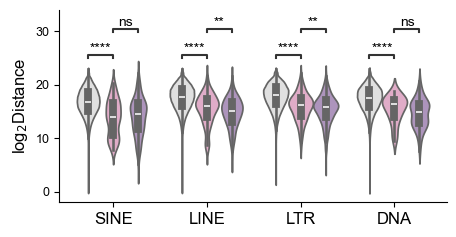

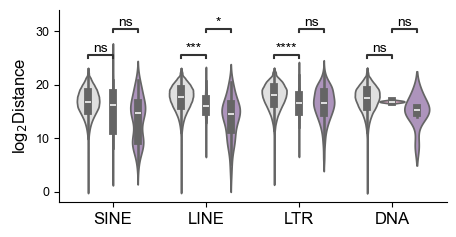

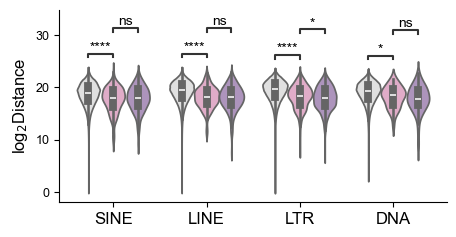

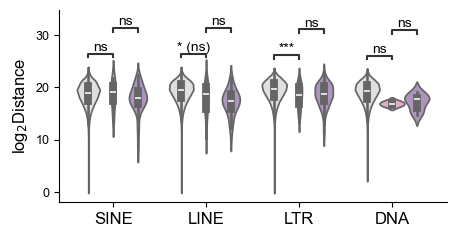

In [47]:
for p, d in itertools.product(ps, ds):
	folder = "figures/" if d == "distal" else "other_figures/"
	if p == "divergent":
		outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig5d.left.pdf"
	else:
		outputfile = f"{PROJECT_DIR_o}{folder}ExtDataFig5d.right.pdf"
	plot_dist(df_dist, p, d, outputfile)